# Regression

In [1]:
%load_ext lab_black

In [2]:
import gpjax
import gpjax.core as gpx
import gpviz as gpv
import jax
import jax.numpy as jnp
import jax.random as jr
from jax.experimental import optimizers
import matplotlib.pyplot as plt

key = jr.PRNGKey(123)
plt.style.use(gpv.__stylesheet__)

## Synthetic datasets

With the necessary libraries and modules imported we can simulate some data. We'll sample our inputs $x$ according to $x_1, \ldots , x_{50} \sim \mathcal{U}(-3., 3)$ and corresponding outputs will be,

$$y_i = \sin(4x_i) + \cos(2 x_i) + \epsilon_i,$$
    
such that $\epsilon_i \sim \mathcal{N}(0, 0.2)$.

In [3]:
N = 50
noise = 0.2

x = jr.uniform(key=key, minval=-3.0, maxval=3.0, shape=(N,)).sort().reshape(-1, 1)
f = lambda x: jnp.sin(4 * x) + jnp.cos(2 * x)
signal = f(x)
y = signal + jr.normal(key, shape=signal.shape) * noise
xtest = jnp.linspace(-3.5, 3.5, 500).reshape(-1, 1)
ytest = f(xtest)

In [4]:
training = gpx.Dataset(X=x, y=y)

To better understand the data that we have simulated, we can plot both the underlying latent function and the observed data which is subject to Gaussian noise.

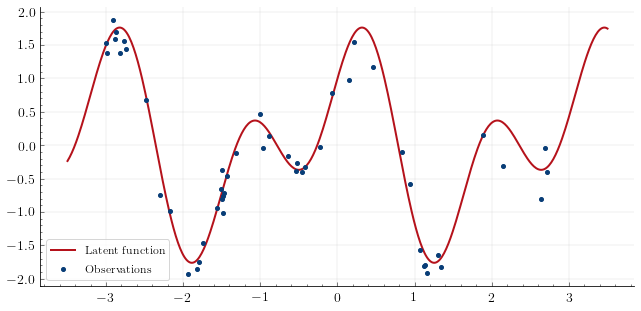

In [5]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(xtest, ytest, label="Latent function")
ax.plot(x, y, "o", label="Observations")
ax.legend(loc="best")

## Defining the GP prior

We can now define model. A zero-mean Gaussian process places a prior over $f$, such that $p(f) \sim \mathcal{N}(0, K_{xx})$ where $K_{xx}$ is the Gram matrix generated by a user-specified kernel function $k$ such that $[K_{xx}]_{i, j} = k(x_i, x_j)$. The choice of kernel function is an important choice as, among other things, it governs the smoothness of the outputs that our Gaussian process can generate. For now, we'll use a squared exponential kernel which takes the form   

$$k(x, x') = \sigma^2 \exp\left(-\frac{\lVert x-x' \rVert_2^2}{2 \ell^2}\right).$$

As we can see, the squared exponential kernel has two parameters; a lengthscale $\ell$ that controls horizontal displacement, and a variance term $\sigma$ that controls vertical displacement.

In [6]:
kernel = gpx.RBF()
prior = gpx.Prior(kernel=kernel)

## Computing the posterior

The posterior distribution is proportional to the prior multiplied by a likelihood function. For this example we'll assume that the likelihood function is a Gaussian distribution. Using this, we can easily compute the posterior using the `*` operator.

In [7]:
lik = gpx.Gaussian()
posterior = prior * lik

### Stating parameters

To store our model's hyperparameters, we suggest using a dictionary. In this example, our kernel is parameterised by a lengthscale and variance parameter. Further, our likelihood functions controls the amount of observation noise; the final parameter that we must optimise. These three quantities should therefore be defined as

In [8]:
params = {
    "lengthscale": jnp.array([1.0]),
    "variance": jnp.array([1.0]),
    "obs_noise": jnp.array([1.0]),
}

For this wishing to simply fit a Gaussian process and not worry about parameter initialisation, the above procedure has been abstracted away through an `initialise` function which can be invoked as follows.

In [9]:
gpx.initialise(posterior)

{'lengthscale': DeviceArray([1.], dtype=float64),
 'obs_noise': DeviceArray([1.], dtype=float64),
 'variance': DeviceArray([1.], dtype=float64)}

For those wishing to specify specific parameters but not worry about others, there is also a `complete` function that will ensure a full and valid set of parameters has been specified for the given model. Running `complete` on a full set of parameters can also be a safety check to ensure that no essential parameters are missing.

In [10]:
from gpjax.parameters import complete

partial_params = {"lengthscale": jnp.array([0.5])}
complete(partial_params, posterior)

{'lengthscale': DeviceArray([0.5], dtype=float64),
 'obs_noise': DeviceArray([1.], dtype=float64),
 'variance': DeviceArray([1.], dtype=float64)}

### Parameter transformation

The three parameters we defined earlier are all strictly positive. To ensure more stable optimisation, it is strongly advised to transform the parameters onto an unconstrained space first. Through the `transform` function and a given bijective transformation function this can be achieved as follows

In [11]:
configs = gpx.get_defaults()
constrainer, unconstrainer = gpx.build_all_transforms(params.keys(), configs)

In [12]:
params = unconstrainer(params)

## Optimisation

To learn the optimal set of hyperparameters, we'll optimise the marginal log-likelihood of the posterior with respect to the hyperparameters. To realise this function, one can run the following.

In [13]:
from jax import jit

mll = jit(gpx.marginal_ll(posterior, transform=constrainer, negative=True))
mll(params, training)

DeviceArray(65.46704582, dtype=float64)

Note that most optimisers (including here) minimise a given function. Truly, we wish to maximise the marginal log-likelihood, so we instead realise the negative marginal log-likelihood so that the minimisation is equivalent to maximising the marginal log-likelihood.

### Defining an optimiser

We can now define an optimiser using one of the optimiser's supplied in Jax's `experimental` module. For this example we'll use the adam optimiser with a step-size of $0.01$.

In [14]:
opt_init, opt_update, get_params = optimizers.adam(step_size=0.01)
opt_state = opt_init(params)

A training routine now can be defined where the `value_and_grad` function in Jax is used to compute the gradient and value of the marginal log-likelihood with respect to our current parameter set.

In [15]:
def step(i, opt_state):
    p = get_params(opt_state)
    v, g = jax.value_and_grad(mll)(p, training)
    return opt_update(i, g, opt_state), v

Optimisation can now be carried out for 500 iterations.

In [16]:
nits = 500
mlls = []

for i in range(nits):
    opt_state, mll_estimate = step(i, opt_state)
    mlls.append(-mll_estimate)

## Optimisation performance

During optimisation, we stored a running estimate of the marginal log-likelihood so that we can retrospectively assess convergence.

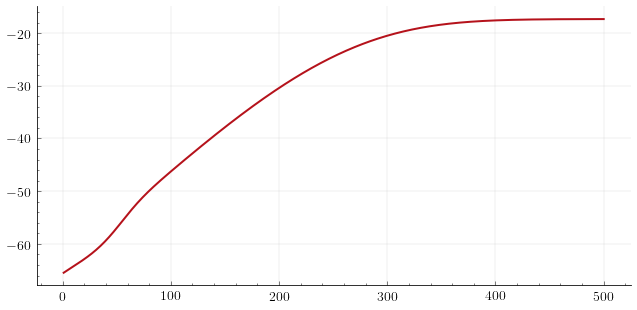

In [17]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(range(1, nits + 1), mlls)

## Learned parameters

The exact value of our learned parameters can often be useful in answering certain questions about the underlying process. To find these values, we should untransfom them so that they are redefined on the original constrained space.

In [18]:
final_params = constrainer(get_params(opt_state))
final_params

{'lengthscale': DeviceArray([0.42745334], dtype=float64),
 'obs_noise': DeviceArray([0.03770831], dtype=float64),
 'variance': DeviceArray([1.23617853], dtype=float64)}

## Prediction

### Direct prediction

Equipped with a posterior distribution and a set of optimised hyperparameter values defined on their original parameter space, we are now in a position to query our GP's predictive posterior distribution at a set of test points. To do this, we can either compute the process' expectation and variance directly using the following `mean` and `variance` functions.

In [19]:
meanf = gpx.mean(posterior, final_params, training)
varf = gpx.variance(posterior, final_params, training)

print(type(meanf))

<class 'function'>


### Realising the random variable

The predictive posterior is itself a Gaussian random variable, and we can compute this quantity using the `random_variable` function. This returns a TensorFlow distribution that is defined in TensorFlow Probability's Jax substrate.

In [20]:
predictive_rv = gpx.random_variable(
    posterior, final_params, training, jitter_amount=1e-6
)(xtest)

Using this random variable, we can directly compute the predictive mean and variance. Note, this yields identical values to the `mean` and `variance` commands from earlier.

In [21]:
mu = predictive_rv.mean()
sigma = predictive_rv.variance()
one_stddev = 1.96 * jnp.sqrt(sigma)

With the predictive mean and variance acquired, we can now visualise how well our GP does at explaining the original data.

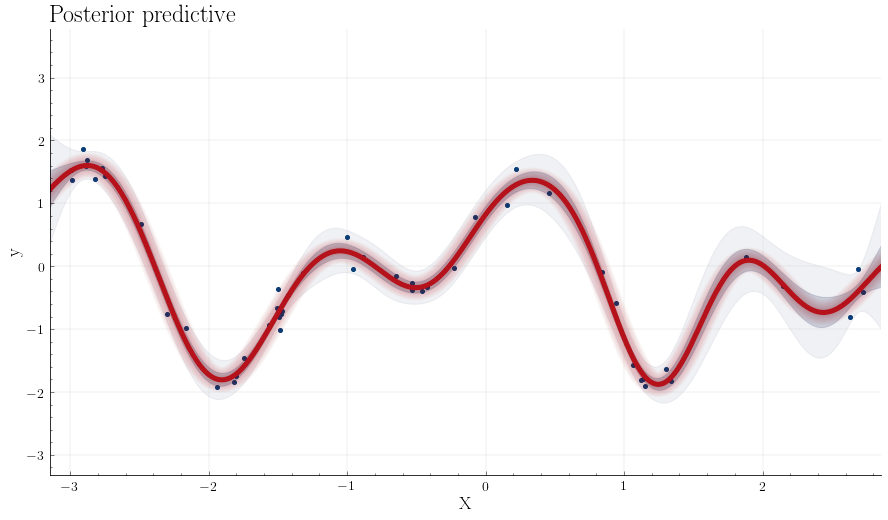

In [22]:
gpv.plot(
    key,
    posterior,
    final_params,
    training,
    xtest,
    std_devs=[1, 3],
    title="Posterior predictive",
)

## Sampling from a GP

Through the `sample` function we are able to draw functions for a given GP at a certain set of points. To demonstrate this, we'll draw samples from the prior and the posterior to observe the difference in our prior beliefs vs the posterior.

In [23]:
prior_samples = gpx.sample(key, prior, params, xtest, n_samples=20)
posterior_samples = gpx.sample(key, predictive_rv, n_samples=20)

Users are, of course, more than welcome to define their own plotting functions. However, such functionality is made readily available through [GPViz](https://github.com/thomaspinder/GPViz).

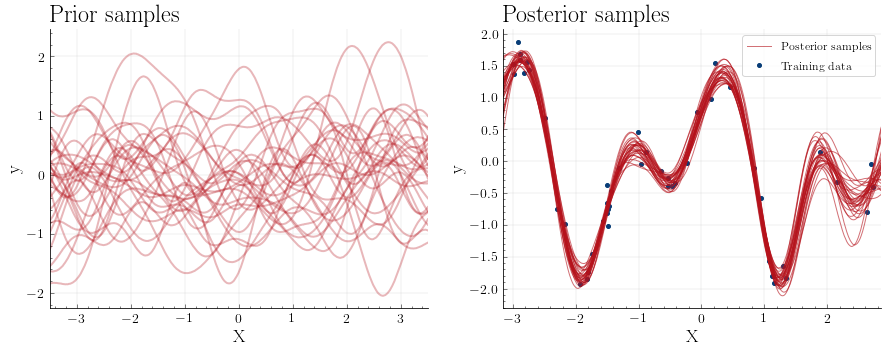

In [27]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 5))
gpv.plot(
    key,
    prior,
    params,
    gpx.Dataset(X=xtest),
    ax=ax[0],
    n_samples=30,
    title="Prior samples",
)
gpv.plot(
    key,
    posterior,
    final_params,
    training,
    xtest,
    n_samples=30,
    std_devs=[],
    legend=True,
    title="Posterior samples",
    mean=False,
    ax=ax[1],
)

## Random variable querying

Up to this point, it may seem an additional complication to realise the random variable instead of just computing the desired quantities directly from the process. However, having direct access to the random variable enables the use of the wealth of functions that are contained in TensorFlow Probability. A full notebook demonstrating this can be found [here (__to add__)](), however, one example is the computation of the Kullback-Leibler divergence from the posterior to the prior.

In [28]:
prior_rv = gpx.random_variable(prior, final_params, gpx.Dataset(X=xtest, y=ytest))
predictive_rv.kl_divergence(prior_rv)

DeviceArray(28.77833728, dtype=float64)

## System information

In [29]:
%reload_ext watermark
%watermark -n -u -v -iv -w -a 'Thomas Pinder'

gpviz 0.0.4
gpjax 0.3.8
jax   0.2.10
Thomas Pinder 
last updated: Mon May 10 2021 

CPython 3.6.9
IPython 7.16.1
watermark 2.0.2
